In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

하이퍼 파라미터 값을 지정하겠습니다.    
하이퍼 파라미터에 대한 설명은 진행하면서 설명드리겠습니다.

In [3]:
#하이퍼 파라미터 튜닝

CFG = {
    'EPOCHS':50, #에포크
    'LEARNING_RATE':1e-2, #학습률
    'BATCH_SIZE':32, #배치사이즈
    'SEED':41, #시드
    'NUM_CLASSES':42,
    'CLASS_NAMES' : ['갈비구이', '갈치구이', '감자전', '경단', '계란국',
        '계란말이', '계란후라이', '고등어구이', '곱창구이', 
        '김밥', '김치볶음밥', '김치전', '꿀떡', '누룽지', 
        '닭갈비', '더덕구이', '동그랑땡', '떡갈비', '떡국_만두국', 
        '무국', '미역국', '북엇국', '불고기', '비빔밥', '삼겹살', 
        '새우볶음밥', '생선전', '송편', '시래기국', '알밥', '유부초밥', 
        '육개장', '잡곡밥', '장어구이', '조개구이', '조기구이', '주먹밥', 
        '콩나물국', '파전', '호박전', '황태구이', '훈제오리']
}

모델의 재현성을 위하여 random seed를 고정하겠습니다.

In [4]:
# Seed 고정
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

## utils

In [5]:
import matplotlib as mpl

print(mpl.matplotlib_fname())

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\mpl-data\matplotlibrc


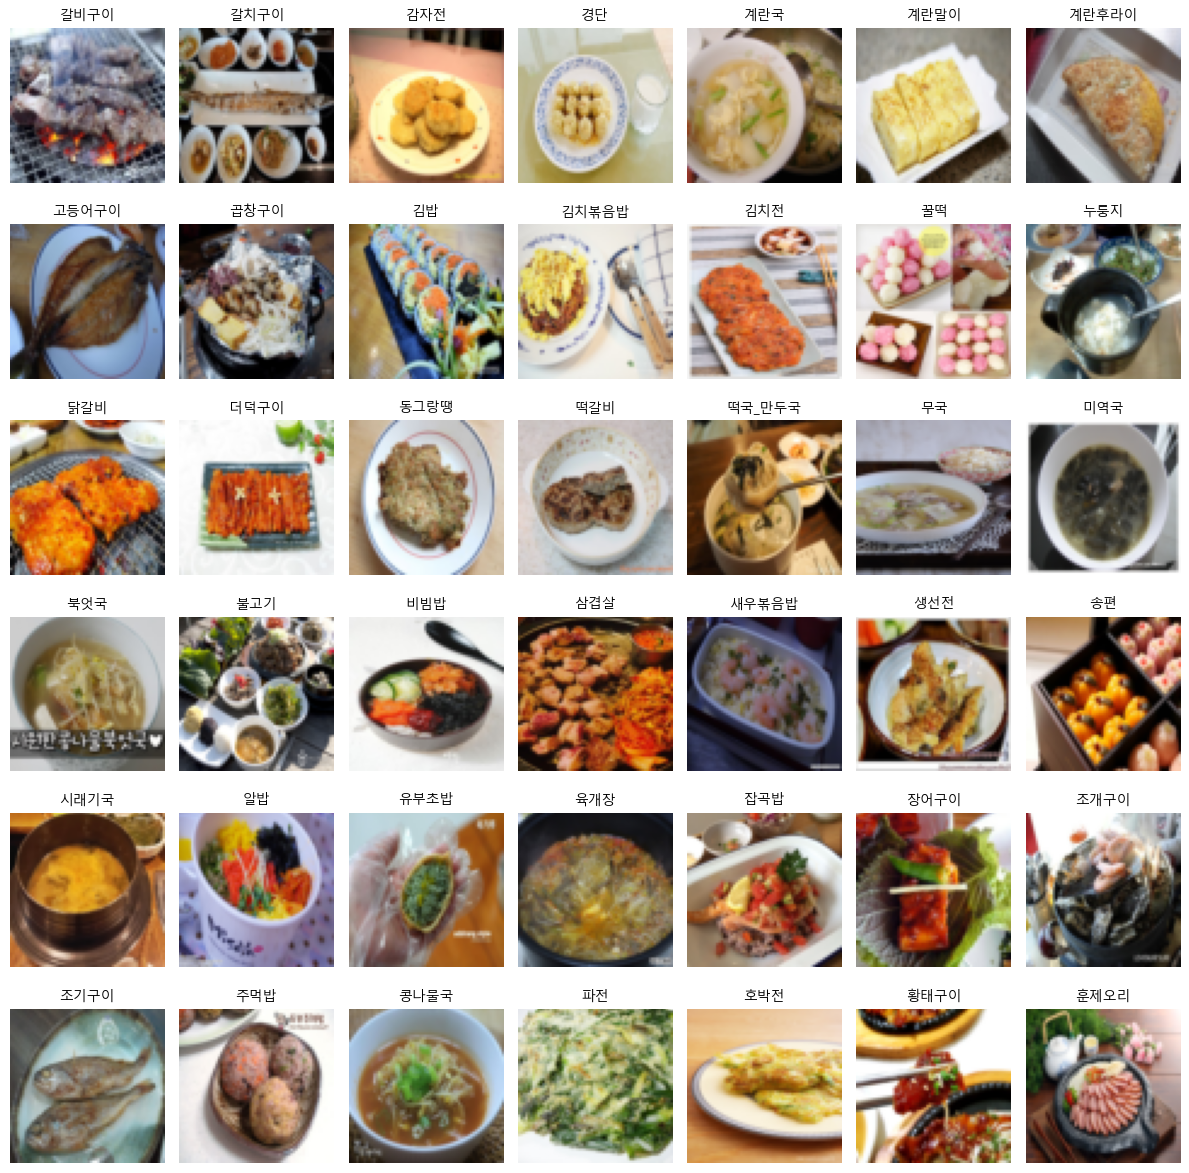

In [15]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import font_manager


# 데이터셋 경로
data_dir = "E:/Data_create_cmap/datasets/kfood_train/train"

# 이미지 전처리 및 변환
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 이미지 크기 조절
    transforms.ToTensor(),  # 이미지를 텐서로 변환
])

# 데이터셋 만들기
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 데이터로더 만들기 - 각 클래스에서 1장씩 가져오기 위해 batch_size를 1로 설정
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 클래스 이름 가져오기
class_names = dataset.classes

# 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 한글 폰트 경로
kr_font = font_manager.FontProperties(fname=font_path)

# 예시 이미지 시각화 - 클래스당 하나의 이미지만 표시
def show_one_image_per_class(dataloader, class_names):
    fig, axes = plt.subplots(6, 7, figsize=(12, 12))
    shown_images = {class_name: 0 for class_name in class_names}  # 각 클래스에서 이미 표시된 이미지 수를 추적하는 딕셔너리

    for images, labels in dataloader:
        class_name = class_names[labels[0]]
        if shown_images[class_name] < 1:  # 각 클래스당 한 장씩만 표시하도록 함
            ax = axes.flatten()[class_names.index(class_name)]
            ax.imshow(images[0].permute(1, 2, 0))
            ax.axis('off')
            ax.set_title(class_name, fontproperties=kr_font)  # 한글 폰트 설정
            shown_images[class_name] += 1

    plt.tight_layout()
    plt.show()

# 이미지 시각화 - 각 클래스당 하나의 이미지만 표시 (총 42개)
show_one_image_per_class(dataloader, class_names)


## train, valuation data load

In [6]:
# 데이터 경로
train_data_dir = "E:/Data_create_cmap/datasets/kfood_train/"
val_data_dir = "E:/Data_create_cmap/datasets/kfood_val/"

## 전처리

In [7]:
# 이미지 변환 및 데이터셋 생성
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

## coustom_dataset , Dataloader

In [8]:
# 데이터셋 경로 설정
train_dataset = ImageFolder(root=train_data_dir + "train", transform=transform)
val_dataset = ImageFolder(root=val_data_dir + "val", transform=transform)


# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle = False)

## Network

In [9]:
# 사전 훈련된 ResNet-18 모델 로딩
model = models.resnet18(pretrained= False)

# pretrained=True: 이 옵션은 사전 훈련된 가중치(pretrained weights)를 사용할 것인지를 지정합니다. 
# True로 설정하면, 이미 ImageNet 데이터셋 등 대규모 데이터셋에서 사전 훈련된 가중치를 불러와 현재 
# 작업에 사용할 수 있습니다. 이것은 전이 학습(transfer learning)을 사용하여 작은 데이터셋에서도 
# 좋은 성능을 얻을 수 있는 강력한 방법 중 하나입니다. 사전 훈련된 모델을 사용하면 초기 가중치가 이미
# 풍부하게 학습되어 있어 더 빠르게 수렴하고 높은 성능을 얻을 수 있습니다.

# 모델의 출력 레이어 변경

model.fc = nn.Linear(model.fc.in_features, CFG['NUM_CLASSES'])

# GPU로 모델 이동
model = model.to(device)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## tain, valuation, EDA

In [10]:
import numpy as np

# 학습 함수 정의
def train_model(model, criterion, optimizer, num_epochs, device, class_names):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    class_correct_train = np.zeros(len(class_names))
    class_total_train = np.zeros(len(class_names))
    
    class_correct_val = np.zeros(len(class_names))
    class_total_val = np.zeros(len(class_names))


    model_save_path = './best_model.pt'  # 원하는 파일 경로 및 이름으로 변경하세요.

    best_val_accuracy = 0.0 
    

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, 
                                    total=len(train_loader),
                                    mininterval=1, 
                                    desc=f'Epoch {epoch+1}/{num_epochs}'):

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # 클래스별 정확도 계산
            for i in range(len(class_names)):
                class_correct_train[i] += ((predicted == labels) & (labels == i)).sum().item()
                class_total_train[i] += (labels == i).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # 검증 데이터에 대한 손실과 정확도 측정
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, 
                                        total=len(val_loader),
                                        mininterval=1, 
                                        desc=f'Validation'):

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                # 클래스별 정확도 계산
                for i in range(len(class_names)):
                    class_correct_val[i] += ((predicted == labels) & (labels == i)).sum().item()
                    class_total_val[i] += (labels == i).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)


    # 클래스별 정확도 출력
    for i in range(len(class_names)):
        class_accuracy_train = 100 * class_correct_train[i] / class_total_train[i]
        class_accuracy_val = 100 * class_correct_val[i] / class_total_val[i]
        print(f"Class {class_names[i]} - Train Accuracy: {class_accuracy_train:.2f}%, Validation Accuracy: {class_accuracy_val:.2f}%")

    # 학습 과정 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy vs. Epochs')

    plt.show()


## main

Epoch 1/50:   0%|          | 0/1050 [00:00<?, ?it/s]

Epoch 1/50:  20%|██        | 211/1050 [02:17<08:27,  1.65it/s]c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 132/132 [01:14<00:00,  1.77it/s]


Epoch 1/50, Train Loss: 3.1320, Train Accuracy: 14.40%, Validation Loss: 3.5944, Validation Accuracy: 11.31%


Validation: 100%|██████████| 132/132 [00:49<00:00,  2.66it/s]


Epoch 2/50, Train Loss: 2.5583, Train Accuracy: 27.09%, Validation Loss: 2.8949, Validation Accuracy: 22.73%


Validation: 100%|██████████| 132/132 [00:49<00:00,  2.68it/s]


Epoch 3/50, Train Loss: 2.1436, Train Accuracy: 36.94%, Validation Loss: 2.4860, Validation Accuracy: 30.35%


Validation: 100%|██████████| 132/132 [00:47<00:00,  2.76it/s]


Epoch 4/50, Train Loss: 1.8363, Train Accuracy: 44.97%, Validation Loss: 3.1135, Validation Accuracy: 22.32%


Validation: 100%|██████████| 132/132 [00:46<00:00,  2.82it/s]


Epoch 5/50, Train Loss: 1.5645, Train Accuracy: 52.49%, Validation Loss: 1.8491, Validation Accuracy: 46.38%


Validation: 100%|██████████| 132/132 [00:47<00:00,  2.76it/s]


Epoch 6/50, Train Loss: 1.3070, Train Accuracy: 59.78%, Validation Loss: 1.9958, Validation Accuracy: 43.97%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.89it/s]


Epoch 7/50, Train Loss: 1.0450, Train Accuracy: 67.60%, Validation Loss: 1.7742, Validation Accuracy: 49.24%


Validation: 100%|██████████| 132/132 [00:46<00:00,  2.82it/s]


Epoch 8/50, Train Loss: 0.7958, Train Accuracy: 74.76%, Validation Loss: 1.7441, Validation Accuracy: 52.55%


Validation: 100%|██████████| 132/132 [00:47<00:00,  2.80it/s]


Epoch 9/50, Train Loss: 0.5517, Train Accuracy: 82.17%, Validation Loss: 1.5368, Validation Accuracy: 58.98%


Validation: 100%|██████████| 132/132 [00:47<00:00,  2.81it/s]


Epoch 10/50, Train Loss: 0.3546, Train Accuracy: 88.57%, Validation Loss: 1.6356, Validation Accuracy: 57.19%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]


Epoch 11/50, Train Loss: 0.2388, Train Accuracy: 92.44%, Validation Loss: 1.9102, Validation Accuracy: 58.50%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.93it/s]


Epoch 12/50, Train Loss: 0.1923, Train Accuracy: 93.81%, Validation Loss: 1.7845, Validation Accuracy: 58.62%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]


Epoch 13/50, Train Loss: 0.1570, Train Accuracy: 94.98%, Validation Loss: 1.9392, Validation Accuracy: 61.41%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.89it/s]


Epoch 14/50, Train Loss: 0.1507, Train Accuracy: 95.26%, Validation Loss: 1.8678, Validation Accuracy: 62.24%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.90it/s]


Epoch 15/50, Train Loss: 0.1116, Train Accuracy: 96.53%, Validation Loss: 2.0274, Validation Accuracy: 58.17%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]


Epoch 16/50, Train Loss: 0.1303, Train Accuracy: 95.95%, Validation Loss: 2.1509, Validation Accuracy: 57.19%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.87it/s]


Epoch 17/50, Train Loss: 0.1040, Train Accuracy: 96.80%, Validation Loss: 2.2378, Validation Accuracy: 60.20%


Validation: 100%|██████████| 132/132 [00:47<00:00,  2.79it/s]


Epoch 18/50, Train Loss: 0.0983, Train Accuracy: 96.93%, Validation Loss: 2.4364, Validation Accuracy: 56.46%


Validation: 100%|██████████| 132/132 [00:44<00:00,  2.93it/s]


Epoch 19/50, Train Loss: 0.1006, Train Accuracy: 96.88%, Validation Loss: 2.2494, Validation Accuracy: 60.62%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.92it/s]


Epoch 20/50, Train Loss: 0.0824, Train Accuracy: 97.42%, Validation Loss: 2.1184, Validation Accuracy: 64.70%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.92it/s]


Epoch 21/50, Train Loss: 0.0939, Train Accuracy: 97.00%, Validation Loss: 2.0523, Validation Accuracy: 62.72%


Validation: 100%|██████████| 132/132 [00:44<00:00,  2.96it/s]


Epoch 22/50, Train Loss: 0.0769, Train Accuracy: 97.63%, Validation Loss: 2.5962, Validation Accuracy: 58.98%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.90it/s]


Epoch 23/50, Train Loss: 0.0792, Train Accuracy: 97.55%, Validation Loss: 2.3946, Validation Accuracy: 60.43%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.93it/s]


Epoch 24/50, Train Loss: 0.0817, Train Accuracy: 97.53%, Validation Loss: 2.4976, Validation Accuracy: 59.55%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.90it/s]


Epoch 25/50, Train Loss: 0.0694, Train Accuracy: 97.89%, Validation Loss: 2.1248, Validation Accuracy: 63.03%


Validation: 100%|██████████| 132/132 [00:46<00:00,  2.87it/s]


Epoch 26/50, Train Loss: 0.0699, Train Accuracy: 97.87%, Validation Loss: 2.7327, Validation Accuracy: 56.79%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.93it/s]


Epoch 27/50, Train Loss: 0.0637, Train Accuracy: 98.13%, Validation Loss: 2.5878, Validation Accuracy: 58.34%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]


Epoch 28/50, Train Loss: 0.0726, Train Accuracy: 97.88%, Validation Loss: 2.2124, Validation Accuracy: 61.89%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.93it/s]


Epoch 29/50, Train Loss: 0.0696, Train Accuracy: 97.87%, Validation Loss: 2.0448, Validation Accuracy: 63.01%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.92it/s]


Epoch 30/50, Train Loss: 0.0624, Train Accuracy: 98.10%, Validation Loss: 2.4245, Validation Accuracy: 60.93%


Validation: 100%|██████████| 132/132 [00:44<00:00,  2.94it/s]


Epoch 31/50, Train Loss: 0.0612, Train Accuracy: 98.14%, Validation Loss: 2.3949, Validation Accuracy: 61.91%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.93it/s]


Epoch 32/50, Train Loss: 0.0567, Train Accuracy: 98.35%, Validation Loss: 2.6588, Validation Accuracy: 61.51%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]


Epoch 33/50, Train Loss: 0.0582, Train Accuracy: 98.19%, Validation Loss: 3.1024, Validation Accuracy: 58.34%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]


Epoch 34/50, Train Loss: 0.0581, Train Accuracy: 98.22%, Validation Loss: 2.5839, Validation Accuracy: 60.65%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]


Epoch 35/50, Train Loss: 0.0468, Train Accuracy: 98.69%, Validation Loss: 2.7910, Validation Accuracy: 60.39%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.89it/s]


Epoch 36/50, Train Loss: 0.0536, Train Accuracy: 98.40%, Validation Loss: 2.7372, Validation Accuracy: 59.93%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.92it/s]


Epoch 37/50, Train Loss: 0.0571, Train Accuracy: 98.23%, Validation Loss: 2.6415, Validation Accuracy: 61.24%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.89it/s]


Epoch 38/50, Train Loss: 0.0488, Train Accuracy: 98.54%, Validation Loss: 2.4799, Validation Accuracy: 62.29%


Validation: 100%|██████████| 132/132 [00:44<00:00,  2.96it/s]


Epoch 39/50, Train Loss: 0.0535, Train Accuracy: 98.39%, Validation Loss: 2.6959, Validation Accuracy: 59.81%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]


Epoch 40/50, Train Loss: 0.0515, Train Accuracy: 98.43%, Validation Loss: 2.6861, Validation Accuracy: 60.72%


Validation: 100%|██████████| 132/132 [00:44<00:00,  2.94it/s]


Epoch 41/50, Train Loss: 0.0466, Train Accuracy: 98.61%, Validation Loss: 2.6599, Validation Accuracy: 60.93%


Validation: 100%|██████████| 132/132 [00:44<00:00,  2.95it/s]


Epoch 42/50, Train Loss: 0.0449, Train Accuracy: 98.64%, Validation Loss: 3.2799, Validation Accuracy: 56.26%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.93it/s]


Epoch 43/50, Train Loss: 0.0474, Train Accuracy: 98.54%, Validation Loss: 2.7672, Validation Accuracy: 61.12%


Validation: 100%|██████████| 132/132 [00:44<00:00,  2.95it/s]


Epoch 44/50, Train Loss: 0.0457, Train Accuracy: 98.57%, Validation Loss: 2.6109, Validation Accuracy: 62.67%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.92it/s]


Epoch 45/50, Train Loss: 0.0481, Train Accuracy: 98.59%, Validation Loss: 2.6565, Validation Accuracy: 63.41%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.89it/s]


Epoch 46/50, Train Loss: 0.0399, Train Accuracy: 98.79%, Validation Loss: 2.5545, Validation Accuracy: 63.79%


Validation: 100%|██████████| 132/132 [00:46<00:00,  2.86it/s]


Epoch 47/50, Train Loss: 0.0454, Train Accuracy: 98.65%, Validation Loss: 2.7259, Validation Accuracy: 63.15%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.88it/s]


Epoch 48/50, Train Loss: 0.0391, Train Accuracy: 98.84%, Validation Loss: 2.5753, Validation Accuracy: 63.77%


Validation: 100%|██████████| 132/132 [00:46<00:00,  2.85it/s]


Epoch 49/50, Train Loss: 0.0499, Train Accuracy: 98.44%, Validation Loss: 3.0081, Validation Accuracy: 59.98%


Validation: 100%|██████████| 132/132 [00:45<00:00,  2.91it/s]


Epoch 50/50, Train Loss: 0.0353, Train Accuracy: 98.99%, Validation Loss: 2.8502, Validation Accuracy: 62.10%
Class 갈비구이 - Train Accuracy: 86.64%, Validation Accuracy: 41.72%
Class 갈치구이 - Train Accuracy: 88.52%, Validation Accuracy: 51.47%
Class 감자전 - Train Accuracy: 84.91%, Validation Accuracy: 40.85%
Class 경단 - Train Accuracy: 86.60%, Validation Accuracy: 48.13%
Class 계란국 - Train Accuracy: 91.33%, Validation Accuracy: 62.00%
Class 계란말이 - Train Accuracy: 86.51%, Validation Accuracy: 43.93%
Class 계란후라이 - Train Accuracy: 91.64%, Validation Accuracy: 61.49%
Class 고등어구이 - Train Accuracy: 86.61%, Validation Accuracy: 48.26%
Class 곱창구이 - Train Accuracy: 88.43%, Validation Accuracy: 45.36%
Class 김밥 - Train Accuracy: 91.13%, Validation Accuracy: 73.06%
Class 김치볶음밥 - Train Accuracy: 90.18%, Validation Accuracy: 61.69%
Class 김치전 - Train Accuracy: 90.14%, Validation Accuracy: 57.55%
Class 꿀떡 - Train Accuracy: 91.99%, Validation Accuracy: 66.04%
Class 누룽지 - Train Accuracy: 88.25%, Validation Accu

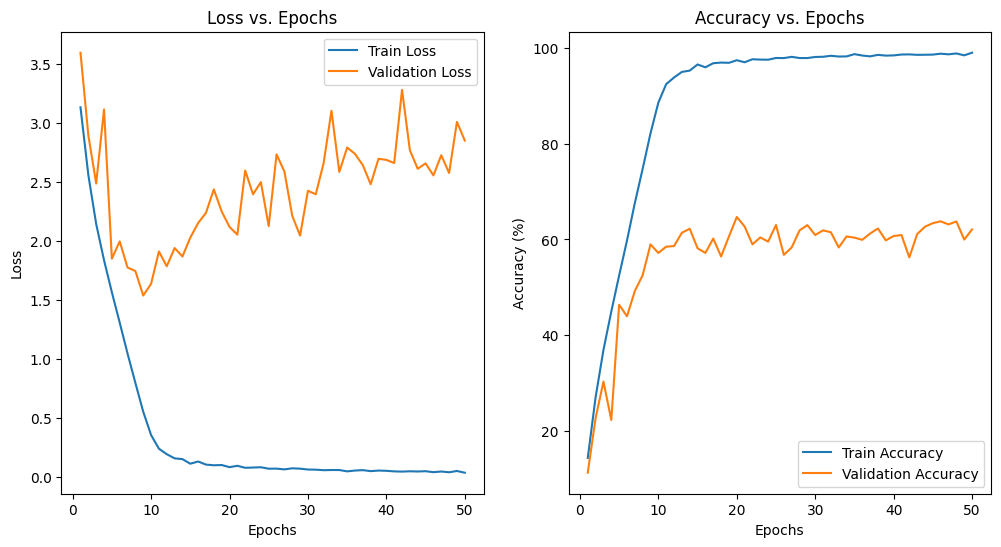

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr = CFG['LEARNING_RATE'])
train_model(model, criterion, optimizer, num_epochs = CFG["EPOCHS"], device = device, class_names = CFG['CLASS_NAMES'])